## Imports and Constants

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
import pickle

TRAIN_FILE = f"./project_data_files/book_rating_train.csv"
TEST_FILE = f"./project_data_files/book_rating_test.csv"
COUNTVEC_FOLDER = f"./project_data_files/book_text_features_countvec/"
DOC2VEC_FOLDER = f"./project_data_files/book_text_features_doc2vec/"
RESULTS_FOLDER = f"./csv_results"
K_FOLD_VAL = 5
CROSS_VAL = True

TEXT_COLUMNS = ['Name', 'Description', 'Authors']

## Utility Functions

In [2]:
import csv
def results_to_csv(filename: str, predictions: list):
    """
    Writes the predictions to a csv file with the given filename to be submitted to Kaggle.
    """
    csv_writer = csv.writer(open(f"{RESULTS_FOLDER}/{filename}", 'w', newline=''))
    rows = []
    rows.append(['id', 'rating_label'])
    for i, prediction in enumerate(predictions):
        rows.append([i+1, prediction])
    csv_writer.writerows(rows)

In [3]:
def count_different_lines(file1, file2):
    # Load the CSV files into Pandas dataframes
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Compare the dataframes and count the number of differences
    diff = (df1 != df2).sum().sum()

    return diff

In [4]:
def count_class_frequency(file_path):
    # Load the CSV file into a Pandas dataframe
    df = pd.read_csv(file_path)

    # Count the frequency of each class in the 'rating_label' column
    class_counts = df['rating_label'].value_counts().to_dict()

    return class_counts

In [5]:
def get_filename(config: dict):
    """
    Returns the filename for the given configuration.
    """

    model = config['model']
    custom_features = '_customfeat' if 'drop_features' in config else ''
    add_countvec_features = '_countvec' if config['add_countvec_features'] else ''
    add_doc2vec_features = '_doc2vec' if config['add_doc2vec_features'] else ''
    top_features = f'_top{config["top_features"]}feat' if config['top_features'] else '_allfeat'
    is_normalise = f'_normalised' if config['is_normalise'] else ''
    imp_type = f'_{config["imp_type"]}imp' if config['imp_type'] else ''
    filename = f"{model}{imp_type}{add_countvec_features}{add_doc2vec_features}{custom_features}{top_features}{is_normalise}.csv"
    print(f"\n ==== FILENAME: {filename} ===\n")
    return filename

## Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from scipy.sparse import coo_matrix
from sklearn.impute import KNNImputer

### Normalisation & Label Encoding

* Using MinMaxScaler that scales and transforms features to a specific range (typically between 0 and 1) by subtracting the minimum value and dividing by the range of the data.

In [7]:
def normalise(df: pd.DataFrame):
    """
    Normalises the given dataframe using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df

In [8]:
def preprocess(filename: str):
    """
    Pre-processes a CSV file by reading it into a pandas DataFrame and dropping the 'filename' column, which is not useful for training.

    Args:
        filename (str): The name of the CSV file to preprocess.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    """
    df = pd.read_csv(filename)
    df = df.drop(columns=TEXT_COLUMNS)

    return df

In [9]:
def label_encode(df):
    # Label encode the 'Publisher' and 'Language' columns
    le = LabelEncoder()
    if 'Publisher' in df:
        df['Publisher'] = le.fit_transform(df['Publisher'])
    if 'Language' in df:
        df['Language'] = le.fit_transform(df['Language'])
    return df

### Feature Selection

* Univariate Feature Selection: Univariate feature selection is a statistical method used to select the features that have the strongest relationship with the target variable. This can be done using techniques such as chi-squared test, mutual information, or ANOVA F-test.
* Using chi-squared test

In [10]:
def top_n_features(X, y, n):
    # Compute the chi-squared scores and p-values for each feature
    chi2_scores, p_values = chi2(X, y)

    # Get the indices of the top k features based on the chi2 scores
    top_feature_indices = chi2_scores.argsort()[::-1][:n]
    
    # Convert the COO matrix to a CSC matrix and select the top k features
    X_top_features = X.tocsc()[:, top_feature_indices]

    return X_top_features, top_feature_indices

* Using the countvec features as they add less features and therefore adds less dimensionality

In [11]:
def add_countvec_features(features, prefix):
    name_vec = scipy.sparse.load_npz(f"{COUNTVEC_FOLDER}/{prefix}_name_vec.npz")
    authors_vec = scipy.sparse.load_npz(f"{COUNTVEC_FOLDER}/{prefix}_authors_vec.npz")
    desc_vec = scipy.sparse.load_npz(f"{COUNTVEC_FOLDER}/{prefix}_desc_vec.npz")

    X = scipy.sparse.hstack((features, name_vec, authors_vec, desc_vec))
    return X

In [12]:
def add_doc2vec_features(features, prefix):
    name_vec = pd.read_csv(f"{DOC2VEC_FOLDER}/{prefix}_name_doc2vec100.csv")
    authors_vec = pd.read_csv(f"{DOC2VEC_FOLDER}/{prefix}_authors_doc2vec20.csv")
    desc_vec = pd.read_csv(f"{DOC2VEC_FOLDER}/{prefix}_desc_doc2vec100.csv")
    X = pd.concat([features, name_vec, authors_vec, desc_vec], axis=1)
    return X

### Data Cleaning

In [13]:
def count_nan(df):
    num_nans = df.isna().sum().sum()
    print(f"Number of NaNs: {num_nans}\n")
    for column in df.columns:
        null_count = df[column].isnull().sum()
        print(f"{column}: {null_count}")
    print()

In [14]:
train_df = pd.read_csv(TRAIN_FILE)
print(f"train_df rows: {train_df.shape[0]}, features: {train_df.shape[1]}\n")

# Check for NaNs
count_nan(train_df)

train_df rows: 23063, features: 10

Number of NaNs: 17350

Name: 0
Authors: 0
PublishYear: 0
PublishMonth: 0
PublishDay: 0
Publisher: 148
Language: 17202
pagesNumber: 0
Description: 0
rating_label: 0



In [15]:
def apply_imputation(df, imp_type: str, test_df):
    print(f"Imputing NaNs with {imp_type}...")
    df = df.copy()

    if imp_type == 'mean':
        train_mean = df.mean().iloc[0]
        df.fillna(train_mean, inplace=True)
        test_df.fillna(train_mean, inplace=True)
    elif imp_type == 'mode':
        train_mode = df.mode().iloc[0]
        df.fillna(train_mode, inplace=True)
        test_df.fillna(train_mode, inplace=True)
    elif imp_type == 'median':
        train_median = df.median().iloc[0]
        df.fillna(train_median, inplace=True)
        test_df.fillna(train_median, inplace=True)
    elif imp_type == 'knn':
        imputer = KNNImputer(n_neighbors=5)
        imputer.fit(df)

        # Perform imputation on the DataFrame
        df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)
        test_df = imputer.transform(test_df)
    else:
        raise ValueError(f"Invalid imputation type: {imp_type}")
    
    return df, test_df

### Combining everything together

In [16]:
def get_dfs(config: dict):
    print("Getting DataFrames...")
    # Preprocess Data
    train_df = preprocess(TRAIN_FILE)
    test_df = preprocess(TEST_FILE)

    # Separate features and labels
    X = train_df.drop('rating_label', axis=1)
    y = train_df['rating_label']
    
    if 'drop_features' in config:
        print(f"Dropping features: {config['drop_features']}")
        X.drop(config['drop_features'], axis=1, inplace=True)
        test_df.drop(config['drop_features'], axis=1, inplace=True)

    # Label Encode
    print("Label encoding...")
    X = label_encode(X)
    test_df = label_encode(test_df)

    if config['is_normalise']:
        print("Normalising...")
        # normalise all rows except the rating_label
        X_copy = X.copy()
        if 'rating_label' in X_copy.columns:
            X = normalise(X_copy.drop('rating_label', axis=1))
            X['rating_label'] = X_copy['rating_label']
        else:
            X = normalise(X)
        test_df = normalise(test_df)

    if config['imp_type'] in ['mode', 'knn']:
        X, test_df = apply_imputation(X, config['imp_type'], test_df)
    
    

    # Add CountVec Features
    if config['add_countvec_features']:
        print("Adding CountVec Features...")
        test_df = add_countvec_features(test_df, "test")
        X = add_countvec_features(X, "train")
    
    # Add Doc2Vec Features
    if config['add_doc2vec_features']:
        print("Adding Doc2Vec Features...")
        test_df = add_doc2vec_features(test_df, "test")
        X = add_doc2vec_features(X, "train")

        nan_indices = X.index[X.isnull().any(axis=1)]
        print(f"Dropping NaNs: {len(nan_indices)} rows have NaN values\n")
        X.drop(nan_indices, inplace=True)
        print(f"len(X): {len(X)}")
        y.drop(nan_indices, inplace=True)
        print(f"len(y): {len(y)}")

    # Select Top Features
    if config['top_features'] > 0:
        print(f"Selecting top {config['top_features']} features...")
        X_top_features, top_feature_indices = top_n_features(X, y, config['top_features'])
        X = X_top_features
        test_df = test_df.tocsc()[:, top_feature_indices]
    
        

    print("get_dfs() complete\n")
    print(f"X rows: {X.shape[0]}, features: {X.shape[1]}")
    print(f"test_df rows: {test_df.shape[0]}, features: {test_df.shape[1]}\n")
    return X, y, test_df

In [17]:
config = {
    'model': 'test',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 100,
    'is_normalise': True,
    'imp_type': 'mode'
}

In [18]:
X, y, test_df = get_dfs(config)

# print(X)

# Find Duplicates
# print(f"num duplicates: {X[X.duplicated()].shape[0]}")
# print(X[X.duplicated()])

print(f"train_df rows: {X.shape[0]}, features: {X.shape[1]}\n")

# Check for NaNs
# count_nan(X)



# X.dropna(inplace=True)

Getting DataFrames...
Label encoding...
Normalising...
Imputing NaNs with mode...
Adding CountVec Features...
Selecting top 100 features...
get_dfs() complete

X rows: 23063, features: 100
test_df rows: 5766, features: 100

train_df rows: 23063, features: 100



In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

def train_and_k_fold(model, X, y, k=5):
    # Initialize lists to store evaluation metrics
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X):
        # Split the data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions and append evaluation metrics
        y_pred = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred, average='macro'))
        recall_scores.append(recall_score(y_val, y_pred, average='macro'))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    
    # Print the average scores across all folds
    print(f"Accuracy: {sum(accuracy_scores) / k}")
    print(f"Precision: {sum(precision_scores) / k}")
    print(f"Recall: {sum(recall_scores) / k}")
    print(f"F1-score: {sum(f1_scores) / k}")

    return model

## Evaluation

In [20]:
def evaluate_train(y_val, y_pred, config):
    # print(metrics.classification_report(y_val, y_pred, zero_division=1))
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(y_val, y_pred, average='macro')
    print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1_score:.3f}')
    # Create confusion matrix
    cm = metrics.confusion_matrix(y_val, y_pred)
    # Normalise confusion matrix
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f', annot_kws={'size': 10},
                xticklabels=['3', '4', '5'],  
                yticklabels=['3', '4', '5'])  
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{config["model"]} Confusion Matrix')
    # plt.savefig(f'./plots/{config["model"]}_confusion_matrix.png')
    plt.show()


In [21]:
def plot_predictions(predictions):
    # plot a bar chart of the predictions  - x axis is the class, which consists of 3, 4, 5
    plt.hist(predictions, bins=[3, 4, 5, 6])
    # make the plot look nicer
    plt.xticks([3, 4, 5])
    plt.xlabel('Predicted Class')
    plt.ylabel('Frequency')
    plt.show()

## Baseline Model: 0R Classifier
* Kaggle Accuracy: 0.70378

Getting DataFrames...
Label encoding...
get_dfs() complete

X rows: 23063, features: 6
test_df rows: 5766, features: 6

Accuracy: 0.703, Precision: 0.234, Recall: 0.333, F1-score: 0.275


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


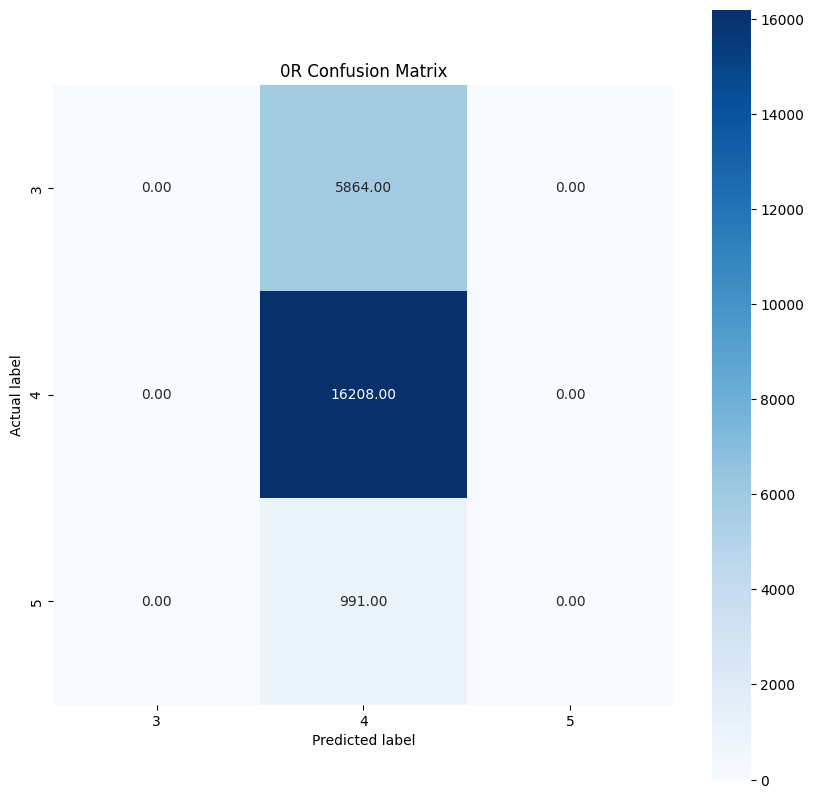

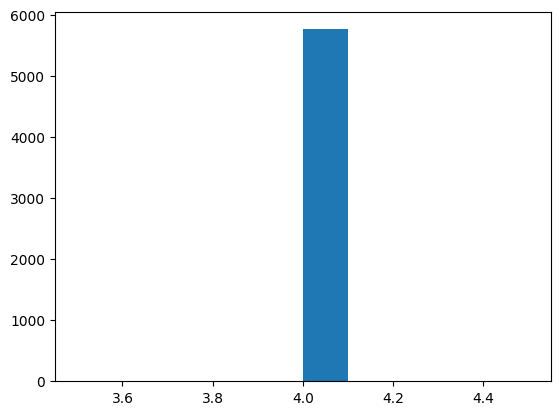

In [22]:
from sklearn.dummy import DummyClassifier

config = {
    'model': '0R',
    'add_countvec_features': False,
    'add_doc2vec_features': False,
    'top_features': 0,
    'is_normalise': False,
    'test_size': 0,
    'imp_type': ''
}
X, y, test_df = get_dfs(config)

zero_r = DummyClassifier(strategy='most_frequent')
zero_r.fit(X, y)

# Predict Labels
predictions = zero_r.predict(test_df)
evaluate_train(y, zero_r.predict(X), config)

# plot a bar chart of the predictions
plt.hist(predictions)

results_to_csv('zero_r.csv', predictions)

## K Nearest Neighbours

In [44]:
# Normalised vs Unnormalised
print(count_different_lines('knn.csv', 'knn_normalised.csv'))
print(count_class_frequency('knn.csv'))
print(count_class_frequency('knn_normalised.csv'))
print(count_class_frequency('knn_countvec.csv'))

1499
{4.0: 4817, 3.0: 921, 5.0: 28}
{4.0: 4753, 3.0: 991, 5.0: 22}
{4.0: 5696, 3.0: 55, 5.0: 15}


Getting DataFrames...
Label encoding...
Normalising...
Adding CountVec Features...
Selecting top 100 features...
get_dfs() complete

X rows: 23063, features: 100
test_df rows: 5766, features: 100

Simple Train-Test Split ===>
Accuracy: 0.688, Precision: 0.672, Recall: 0.352, F1-score: 0.337


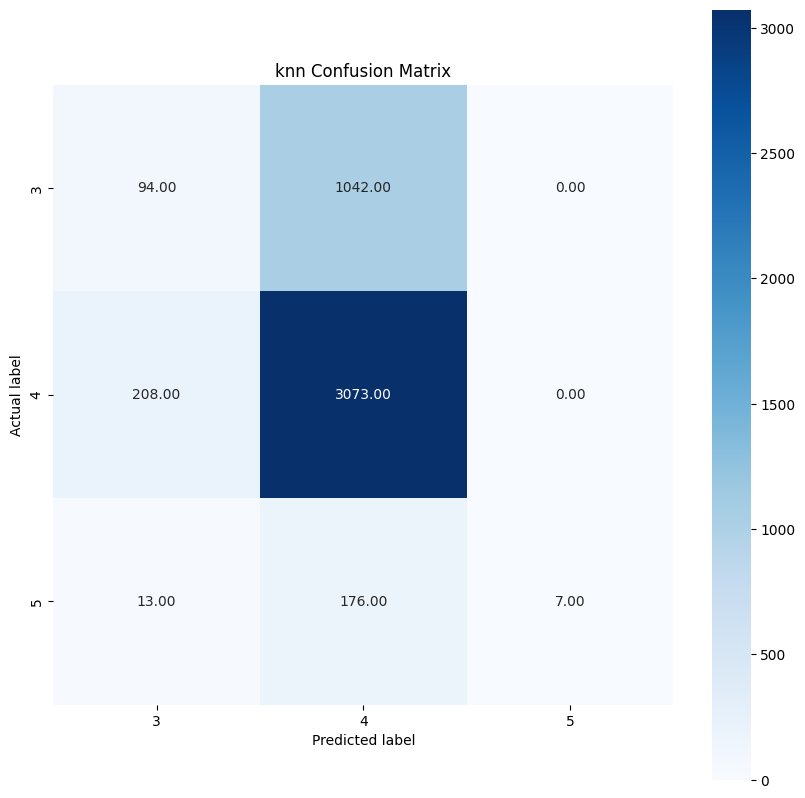

len(predictions): 5766


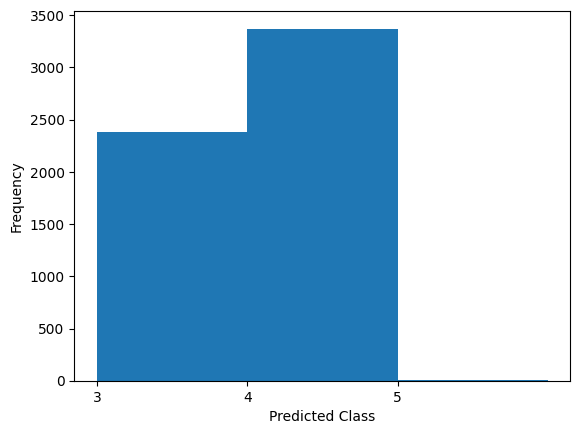


 ==== FILENAME: knn_countvec_top100feat_normalised.csv ===


 ==== FILENAME: knn_countvec_top100feat_normalised.csv ===

knn_countvec_top100feat_normalised.csv


In [27]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

config = {
    'model': 'knn',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 100,
    'is_normalise': True,
    'imp_type': ''
}

X, y, test_df = get_dfs(config)

# check if X is a pd.DataFrame
if not isinstance(X, pd.DataFrame):
    X = X.toarray()
# split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

if CROSS_VAL:
    print('Cross Validation ===>')
    kf = KFold(n_splits=K_FOLD_VAL, shuffle=True, random_state=42)

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X):
        # Split the data into training and validation sets
        X_train, X_test = X.iloc[train_index], X.iloc[val_index]
        y_train, y_test = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        knn_model = KNeighborsClassifier(
            n_neighbors=5,
            weights='uniform',
            algorithm='auto',
            leaf_size=30,
            p=2,
            metric='minkowski',
            n_jobs=-1
        )
        knn_model.fit(X_train, y_train)

        # Make predictions and append evaluation metrics
        y_pred = knn_model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred, average='macro'))
        recall_scores.append(recall_score(y_val, y_pred, average='macro'))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))

    # Calculate the average performance metrics
    accuracy_avg = np.mean(accuracy_scores)
    precision_avg = np.mean(precision_scores)
    recall_avg = np.mean(recall_scores)
    f1_avg = np.mean(f1_scores)

    # Print the average performance metrics to 2dp
    print(f"Accuracy: {accuracy_avg:.3f}")
    print(f"Precision: {precision_avg:.3f}")
    print(f"Recall: {recall_avg:.3f}")
    print(f"F1-score: {f1_avg:.3f}")
else:
    print("Simple Train-Test Split ===>")
    
    knn_model = KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
        n_jobs=-1
    )
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_val)
    evaluate_train(y_val, y_pred, config)

knn_model.fit(X, y)
predictions = knn_model.predict(test_df)
print(f"len(predictions): {len(predictions)}")

plot_predictions(predictions)

# Export Results
results_to_csv(get_filename(config), predictions)
print(get_filename(config))

## Support Vector Machine

In [56]:
# Normalised vs Unnormalised
print(count_different_lines('svm.csv', 'svm_normalised.csv'))
print(count_class_frequency('svm.csv'))
print(count_class_frequency('svm_normalised.csv'))

2
{4.0: 5757, 5.0: 9}
{4.0: 5757, 5.0: 9}


Getting DataFrames...
Label encoding...
Normalising...
Adding CountVec Features...
get_dfs() complete

X rows: 23063, features: 126890
test_df rows: 5766, features: 126890

Accuracy: 0.714, Precision: 0.877, Recall: 0.340, F1-score: 0.291


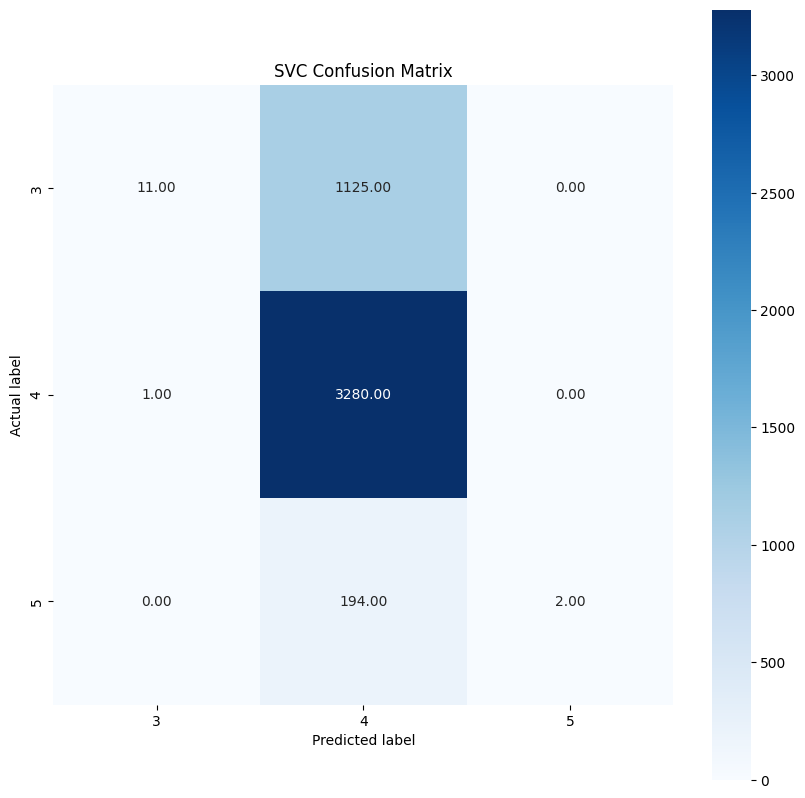

len(predictions): 5766


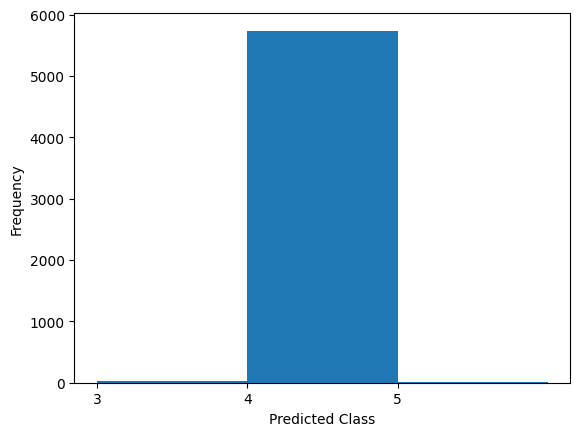


 ==== FILENAME: SVC_countvec_allfeat_normalised.csv ===



In [59]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

config = {
    'model': 'SVC',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 0,
    'is_normalise': True,
    'test_size': 0,
    'imp_type': ''
}
X, y, test_df = get_dfs(config)

svm_model = SVC(
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=1e-3,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None
)

if CROSS_VAL:
    accuracy = np.mean(cross_val_score(svm_model, X, y, cv=5))
    f1 = np.mean(cross_val_score(svm_model, X, y, cv=5, scoring='f1_macro'))

    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
else:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)
    evaluate_train(y_val, y_pred, config)

svm_model.fit(X, y)

predictions = svm_model.predict(test_df)
print(f"len(predictions): {len(predictions)}")

# plot a bar chart of the predictions
plot_predictions(predictions)

# Export Results
results_to_csv(get_filename(config), predictions)

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel function
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

config = {
    'model': 'SVC',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 0,
    'is_normalise': True,
    'test_size': 0,
    'imp_type': ''
}

X, y, test_df = get_dfs(config)

# Create the SVM model
svm_model = SVC(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)  # X and y are your input features and labels

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Getting DataFrames...
Label encoding...
Normalising...
Adding CountVec Features...
get_dfs() complete

X rows: 23063, features: 126890
test_df rows: 5766, features: 126890



## Extreme Gradient Boosting

In [21]:
print(count_class_frequency('xgb_1.csv'))
print(count_class_frequency('xgb_countvec.csv'))
print(count_class_frequency('xgb_countvec_allfeat.csv'))
print(count_class_frequency('xgb_countvec_allfeat_minmaxscaler.csv'))

{4.0: 5745, 5.0: 19, 3.0: 2}
{4.0: 5681, 3.0: 72, 5.0: 13}
{4.0: 5681, 3.0: 72, 5.0: 13}
{4.0: 5704, 3.0: 49, 5.0: 13}


Getting DataFrames...
Label encoding...
Normalising...
Adding CountVec Features...
get_dfs() complete

X rows: 23063, features: 126890
test_df rows: 5766, features: 126890

Accuracy: 0.721, Precision: 0.720, Recall: 0.377, F1-score: 0.366


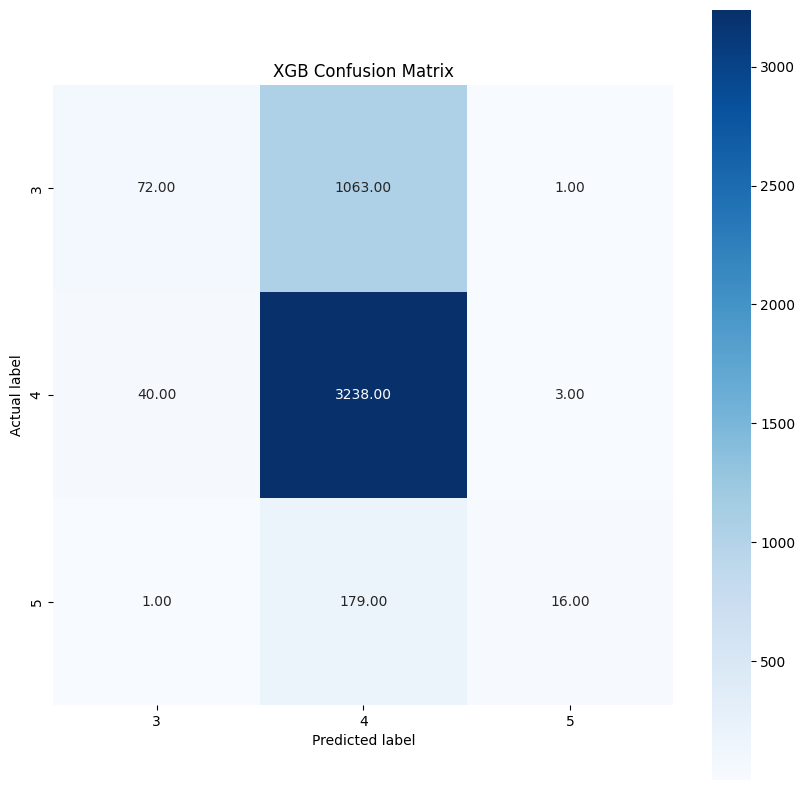

len(predictions): 5766


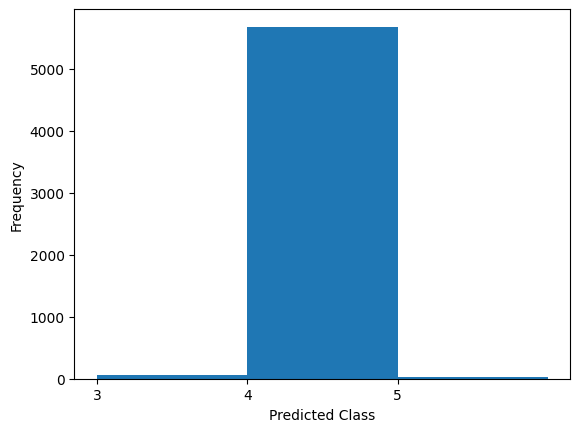


 ==== FILENAME: XGB_countvec_allfeat_normalised.csv ===


 ==== FILENAME: XGB_countvec_allfeat_normalised.csv ===

XGB_countvec_allfeat_normalised.csv


In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

config = {
    'model': 'XGB',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 0,
    'is_normalise': True,
    'imp_type': ''
}

X, y, test_df = get_dfs(config)

# Labels need to be 0, 1, 2
y = y.astype(int) - 3

# Define the model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='merror',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    seed=42
)

if CROSS_VAL:
    accuracy = np.mean(cross_val_score(xgb_model, X, y, cv=5))
    f1 = np.mean(cross_val_score(xgb_model, X, y, cv=5, scoring='f1_macro'))

    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
else:
    # Simple Train/Test Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    evaluate_train(y_val, y_pred, config)

# Predict on the test set
xgb_model.fit(X, y)
predictions = xgb_model.predict(test_df) + 3.0
print(f"len(predictions): {len(predictions)}")

# plot a bar chart of the predictions
plot_predictions(predictions)

# Export Results
results_to_csv(get_filename(config), predictions)
print(get_filename(config))

### Hyperparameter Tuning
* Using grid search/random search and 5-fold cross-validation; scoring based on accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Preprocess Data
train_df = preprocess(TRAIN_FILE)
test_df = preprocess(TEST_FILE)

features = train_df.drop('rating_label', axis=1)
labels = train_df['rating_label'].astype(int) - 3

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [50, 100, 200],
}

# Define the model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='merror',
    seed=42
)

# Define the F1 scorer
scorer = make_scorer(f1_score, average='macro')

# Run the grid search
grid_search = GridSearchCV(
    xgb_model, param_grid, scoring=scorer,
    cv=5, n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


## Random Forest

In [106]:
print(count_class_frequency('./csv_results/RF_countvec_allfeat_normalised.csv'))
print(count_class_frequency('./csv_results/RF_knnimp_countvec_allfeat_normalised.csv'))
print(count_class_frequency('./csv_results/RF_modeimp_countvec_allfeat_normalised.csv'))
print(count_different_lines('./csv_results/RF_countvec_allfeat_normalised.csv', './csv_results/RF_knnimp_countvec_allfeat_normalised.csv'))

{4.0: 5710, 3.0: 41, 5.0: 15}
{4.0: 5710, 3.0: 41, 5.0: 15}
{4.0: 5716, 3.0: 35, 5.0: 15}
0


Getting DataFrames...
Dropping features: ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber', 'Language']
Label encoding...
Normalising...
Adding CountVec Features...
get_dfs() complete

X rows: 23063, features: 126885
test_df rows: 5766, features: 126885



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.6s finished


Accuracy: 0.721, Precision: 0.832, Recall: 0.364, F1-score: 0.340


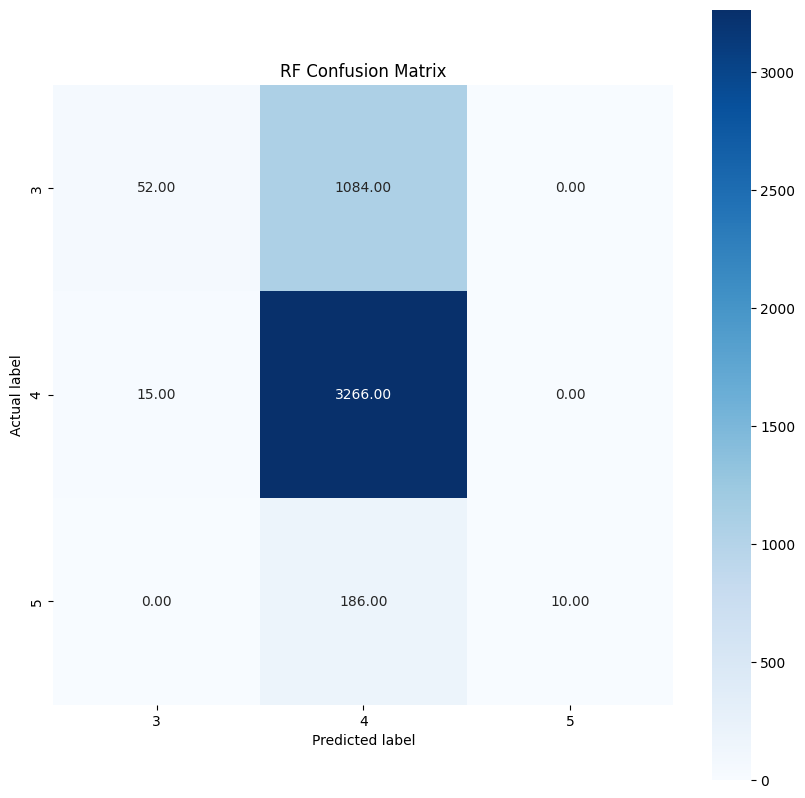

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished


len(predictions): 5766


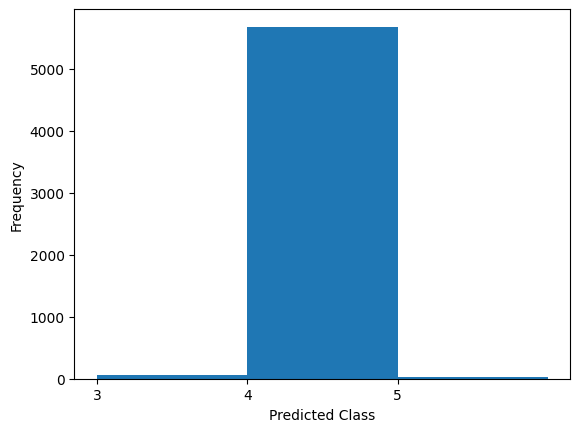


 ==== FILENAME: RF_countvec_customfeat_allfeat_normalised.csv ===



In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import make_scorer, f1_score

# # Create a FeatureHasher object with 1000 output features
# hasher = FeatureHasher(n_features=1000, input_type='string')

# # Hash the "author" column in the training data
# X_train_author_hashed = hasher.transform(X_train['author'])

# # Hash the "author" column in the test data
# X_test_author_hashed = hasher.transform(X_test['author'])


config = {
    'model': 'RF',
    'add_countvec_features': True,
    'add_doc2vec_features': False,
    'top_features': 0,
    'is_normalise': True,
    'imp_type': '',
    'drop_features': ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber', 'Language']
}
X, y, test_df = get_dfs(config)

# Train/Validate Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Define Model
rf_model = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

if CROSS_VAL:
    accuracy = np.mean(cross_val_score(rf_model, X, y, cv=5))
    f1 = np.mean(cross_val_score(rf_model, X, y, cv=5, scoring='f1_macro'))
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
else:
    # Train Model
    rf_model.fit(X_train, y_train)

    # Predict Labels on training set and evaluate
    y_pred = rf_model.predict(X_val)
    evaluate_train(y_val, y_pred, config)

rf_model.fit(X, y)

# Predict Labels on test set
predictions = rf_model.predict(test_df)
print(f"len(predictions): {len(predictions)}")

# plot a bar chart of the predictions
plot_predictions(predictions)

# Export Results
results_to_csv(get_filename(config), predictions)


### Hyperparamater Tuning

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Different number of trees
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
}

X, y, test_df = get_dfs(config)

# Create the random forest model
rf_model = RandomForestClassifier(
    criterion='gini',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Define the F1 scorer
scorer = make_scorer(f1_score, average='macro')

# Perform grid search with F1 scoring
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X, y)  # X and y are your input features and labels

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Getting DataFrames...
Label encoding...
Normalising...
Imputing NaNs with mode...
Adding CountVec Features...
get_dfs() complete

X rows: 23063, features: 126890
test_df rows: 5766, features: 126890



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1

Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
